# BMM for the EOS of symmetric nuclear matter: pointwise approach

## Alexandra Semposki

### Date last edited: 01 April 2024

This annotated notebook presents the results from Section III B of our paper, and utilizes the pointwise approach to Bayesian model mixing, detailed in Section III A.

We would like to model mix the chiral EFT EOS with the perturbative QCD EOS for symmetric nuclear matter (SNM). In this notebook, we directly use the two EOSs without any intermediate interpolation---simply mixing the Gaussian random variables of the two theories. To do this, we do need to extend the EOS from $\chi$EFT to densities much higher than $\chi$EFT can describe---we accomplish this by implementing the PAL EOS from [Prakash et al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.61.2518). This is then our "mean function" past the cutoff of the MBPT data ($\approx 2 n_{0}$); to obtain the truncation error, we allow the BUQEYE truncation error calculation, which is already being used for the $\chi$EFT uncertainty bands, to continue until the place where the expansion parameter $Q = 1$, after which we set the truncation error to a very large value and effectively quench this model, such that the model mixing will no longer give weight to it. This will be seen more clearly from the results below. 

To perform the model mixing, we use the BAND software package `Taweret` (see [here](https://github.com/bandframework/Taweret) for the open-source GitHub repository). This package does the combination of the Gaussian random variables (means and variances in the quantity $P(n)$, the pressure) point-by-point across the input space (here, the number density, $n$).

#### Table of contents

1. [Bayesian Model Mixing via Taweret](#bmm_taweret)
1. [Speed of sound calculaton](#cs2_taweret)

---

In [1]:
# first we import packages
%load_ext autoreload
%autoreload 2

import gsum as gm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.integrate as scint
import scipy.interpolate as scinterp
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator
import scipy.stats as stats
import os
import sys
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize as opt
import pandas as pd
from collections import defaultdict
%matplotlib inline

In [2]:
# import Taweret from the top level
import sys
sys.path.append('../../Taweret') # *** uncomment this line to run ***
sys.path.append('../../Taweret/src')
sys.path.append('../data/')
sys.path.append('../src')
#! pip install pytest

# import nuclear-matter-convergence for Fermi momentum calculation
sys.path.append('../nuclear-matter-convergence/')
from nuclear_matter import fermi_momentum, nuclear_density

# import from Taweret all modules
from Taweret.core.base_model import BaseModel
from Taweret.mix.gaussian import Multivariate

In [3]:
# import plotting script
from scripts import *
setup_rc_params()

# import speed of sound calculation
from eos_utils import speed_of_sound

---

## Pointwise Bayesian model mixing via Taweret <a id="bmm_taweret"></a>

### Training data and model evaluations

Below we will load in the data that we have previously calculated from the $\chi$EFT calculations in the `EOS_ChEFT.ipynb` notebook and that from the perturbative QCD calculations in the `pQCD_EOS.ipynb` notebook. To do this in a way that `Taweret` will understand, we will need to build simple classes for both theories, since `Taweret` requires each input model to have a corresponding class that conforms to its `BaseModel` function specifications. This is to ensure the package uses the data properly. 

We build both the $\chi$EFT and pQCD classes below.

In [4]:
# define needed constants
n0 = 0.164     # fm^-3
hbarc = 197.327 # MeV fm

In [5]:
# chiral class for Taweret
class ChiralModel(BaseModel):
    
    def __init__(self):    
        
        # import the data set
        chiral_data = np.load('../data/eos_data/pressure_chiral_data_scaled_PAL.npz')  # chiral + PAL data
        self.dens_test = chiral_data['density']  # call outside later on 
        self.mean_test = chiral_data['mean'][:,3]
        self.std_test = chiral_data['std_dev'][:,3]  # last order -> N3LO = 3
                
        return None
    
    # mean and std here imported from data set
    def evaluate(self, density=None):
        
        # return the arrays for mixing
        return self.mean_test, self.std_test
    
    # define prior function
    def set_prior(self):       
        return None 
    
    # define likelihood
    def log_likelihood_elementwise(self):       
        return None
    
    
# pQCD class for Taweret
class PQCDModel(BaseModel):
    
    def __init__(self): 
        
        # import the data set here
        pqcd_data = np.load('../data/eos_data/pressure_pqcd_data_scaled.npz')
        self.dens_test = pqcd_data['density']  
        self.mean_test = pqcd_data['mean'][:,2]
        self.std_test = pqcd_data['std_dev'][:,2]   # last order -> N2LO = 2
        
        return None
    
    # mean and std here imported from data set
    def evaluate(self, density=None):
        
        # return the arrays for mixing from the GP
        return self.mean_test, self.std_test
    
    # define prior function
    def set_prior(self):       
        return None 
    
    # define likelihood
    def log_likelihood_elementwise(self):       
        return None
    
# instantiate chiral model here
chiral_eos = ChiralModel()
mean_chiral, std_dev_chiral = chiral_eos.evaluate()
density_chi = chiral_eos.dens_test
    
# instantiate pQCD model here
pqcd_eos = PQCDModel()
mean_pqcd, std_dev_pqcd = pqcd_eos.evaluate()
density_pqcd = pqcd_eos.dens_test

# check the densities are equal (crucial for this model mixing approach!)
if density_chi.all() == density_pqcd.all():
    density = density_chi
else:
    raise ValueError('Densities from chiral EFT and pQCD do not match; cannot mix!')

Once we have our density array set up and our two models, we send them in a `dict` to `Taweret` and predict the mixed model result.

In [6]:
# mix our models by setting them up and sending to Taweret
models = {
    "chiral" : chiral_eos,
    "pqcd" : pqcd_eos,
}

# instantiate Multivariate class from Taweret
mixed_model = Multivariate(density, models, n_models=len(models))

# call predict and return the mean, intervals, and std_dev
_, mixed_mean, mixed_intervals, mixed_std_dev = mixed_model.predict(ci=68)

Now, we also want to include in the plot the results from [Danielewicz et al.](https://www.science.org/doi/10.1126/science.1078070) and [Leonhardt et al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.125.142502). To do this the data from the functional renormalization group (FRG) (latter reference) must be scaled to the Fermi gas pressure, as the two models have already been scaled, so we do this using the data file and interpolation below.

In [7]:
# use the conversion from the pQCD code to convert the contour data from HIC, FRG
convert_pqcd = np.load('../data/eos_data/pqcd_fg_data.npz')

# interpolate for a functional form to use 
convert_interp = scinterp.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
                                  kind='cubic', fill_value='extrapolate')
pqcd_convert_arr = convert_interp(density)

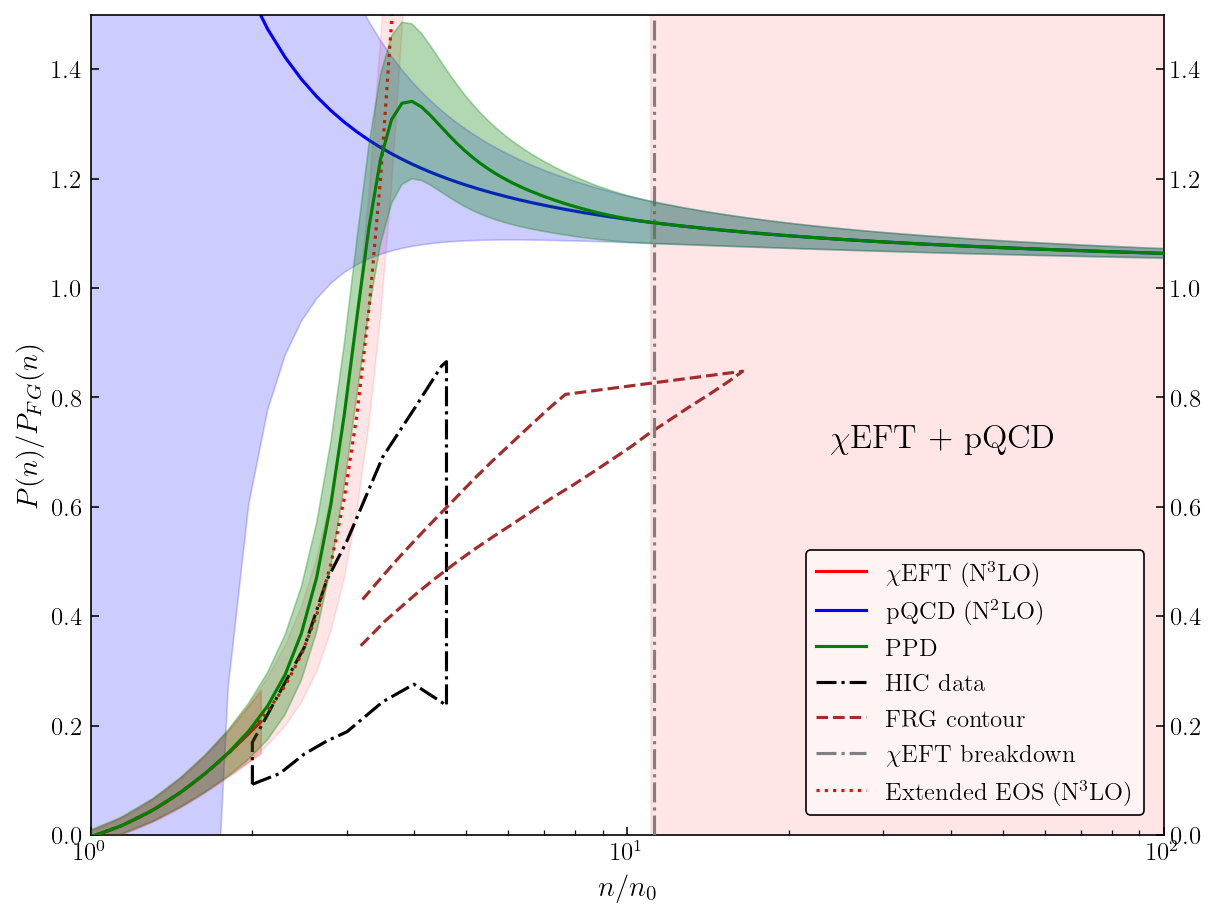

In [8]:
# plot BMM result and overlay the HIC, FRG contours from data files
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(1., max(density/n0))
ax.set_ylim(0.0,1.5)
ax.tick_params(axis='both', which='major', labelsize=12, labelright=True, right=True)
ax.tick_params(axis='both', which='minor', labelsize=10, labelright=True)
ax.text(0.9,0.5, r'$\chi$EFT + pQCD', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)

colors = ['r', 'b', 'g']
labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed model', \
          r'Extended EOS (N$^{3}$LO)']

# model mean from chiral EFT
real_chiral = np.load('../data/eos_data/pressure_chiral_data_scaled_2n0.npz')
ax.fill_between(real_chiral['density']/n0, real_chiral['mean'][:,3]-real_chiral['std_dev'][:,3], \
                real_chiral['mean'][:,3]+real_chiral['std_dev'][:,3], color='red', zorder=15, alpha=0.2)
ax.plot(real_chiral['density']/n0, real_chiral['mean'][:,3], label=labels[0], color='red', zorder=15)

# model mean from pQCD
ax.plot(density/n0, mean_pqcd, color=colors[1], label=labels[1])

# mixed model mean
ax.plot(density/n0, mixed_mean, color='g', label='PPD', zorder=19)

# model uncertainties from chiral EFT + PAL, pQCD
ax.fill_between(density/n0, mean_chiral - 1.0*std_dev_chiral, mean_chiral + 1.0*std_dev_chiral, \
                color=colors[0], alpha=0.1)
ax.fill_between(density/n0, mean_pqcd - 1.0*std_dev_pqcd, mean_pqcd + 1.0*std_dev_pqcd, \
                color=colors[1], alpha=0.2)

# mixed model uncertainty band
ax.fill_between(density/n0, mixed_mean-1.0*mixed_std_dev, mixed_mean+1.0*mixed_std_dev,
                        zorder=18, facecolor='g', edgecolor='g', alpha=0.3)

# import contours from heavy ion collisions and FRG EOS
df = pd.read_csv('../data/contour_scaled.csv')
df_frg = pd.read_csv('../data/frg_data_pressure.csv')

# FRG unscaling 
pressure_free = np.zeros([len(df_frg['n/n0'])])
p_fg = np.zeros([len(density)])

# contour kf_s calculated here for the Fermi momentum
contour_kf_s_fg = fermi_momentum(density=density, degeneracy=4)
contour_kf_s = fermi_momentum(density=0.164*df_frg['n/n0'], degeneracy=4)
for i in range(len(df_frg['n/n0'])):
    pressure_free[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s[i]**4.0))*(hbarc)
for i in range(len(density)):
    p_fg[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s_fg[i]**4.0))*(hbarc)
    
# unscale FRG
frg_unscaled = df_frg['P/P_free']*pressure_free
ax.plot(df['Density/n0'], df['p_pfg'], color='k', linestyle='dashdot', label='HIC data')
ax.plot(df_frg['n/n0'], df_frg['P/P_free'], color='brown', linestyle='dashed', label='FRG contour')

# Q=1 location of chiral EFT
ax.axvline(x=1.84/n0, color='grey', linestyle='dashdot', zorder=10, label=r'$\chi$EFT breakdown')

# mean for chiral EFT + PAL
ax.plot(density/n0, mean_chiral, linestyle='dotted', color=colors[0], label=labels[3])

# legend
ax.set_xscale('log')
ax.legend(loc='lower right', fontsize=12)
plt.show()

## Speed of sound calculation, $c_{s}^{2}(n)$ <a id="cs2_taweret"></a>

We need to extract the speed of sound from the mixed model pressure, which we just plotted. The most direct way to do this is to integrate the $P(n)$ curve to get the energy density. 

$$
P(n) = n^{2} \frac{\partial (\varepsilon/n)}{\partial n}
$$

$$
\varepsilon(n) = n \left[\int_{n_{i}}^{n} \frac{P(n)}{n^{2}} dn + \frac{\varepsilon(n_{i})}{n_{i}} \right],
$$

where $n_{i}$ is 0.05 fm$^{-3}$.

After we achieve the energy density in this manner, we will then code the chemical potential as

$$
\mu(n) = \frac{P(n) + \varepsilon(n)}{n},
$$

and finally obtain the speed of sound, given as

$$
c_{s}^{2}(n) = \frac{\partial P}{\partial n } / \frac{\partial \varepsilon}{\partial n} = \frac{1}{\mu(n)} \frac{\partial P(n)}{\partial n}.
$$

In [10]:
# take the energy density from chiral EFT and find the value needed
# for the initial point of the density (0.05 fm^-3)
edens_data = np.load('../data/eos_data/edens_data_chiral.npz')

# call the energy density data set and interpolate
edens_interp = scinterp.interp1d(edens_data['density'], edens_data['mean'], kind='cubic', \
                                 fill_value='extrapolate')
edens_interp_std = scinterp.interp1d(edens_data['density'], edens_data['std'], kind='cubic', \
                                     fill_value='extrapolate')
en_0 = edens_interp(0.164)
en_0_lower = en_0 - edens_interp_std(0.164)
en_0_upper = en_0 + edens_interp_std(0.164)

# create dict of energy densities for mean, upper, and lower bands
edens_dict = {
    'mean': en_0, 
    'lower': en_0_lower,
    'upper': en_0_upper
}

# load in the saved data from pQCD and interpolate for P_FG scaling
p_fg_scaling = np.load('../data/eos_data/pqcd_fg_data.npz')
p_fg_interp = scinterp.interp1d(p_fg_scaling['density'], p_fg_scaling['mean'], kind='cubic', \
                               fill_value='extrapolate')
p_fg = p_fg_interp(density)

p_mean_interp = scinterp.interp1d(density[1:], (mixed_mean[1:]*p_fg[1:]), kind='cubic', \
                                  fill_value='extrapolate')
p_lower_interp = scinterp.interp1d(density[1:], ((mixed_mean[1:]-mixed_std_dev[1:])*p_fg[1:]), \
                                   kind='cubic', fill_value='extrapolate')
p_upper_interp = scinterp.interp1d(density[1:], ((mixed_mean[1:]+mixed_std_dev[1:])*p_fg[1:]), \
                                   kind='cubic', fill_value='extrapolate')

# pressure dict for input to speed of sound
pres = {
    'mean': (mixed_mean*p_fg)[1:],
    'std_dev': (mixed_std_dev*p_fg)[1:]
}

# output of speed of sound function
dens_cs2, cs2_result, _, edens_result, _= speed_of_sound(density[1:], pres, edens_dict, \
                                                 sat=True, integrate='forward')
cs2_mean = cs2_result['mean']
cs2_lower = cs2_result['lower']
cs2_upper = cs2_result['upper']

Now we want to plot the speed of sound of chiral EFT, pQCD, and the mixed model. We do this below.

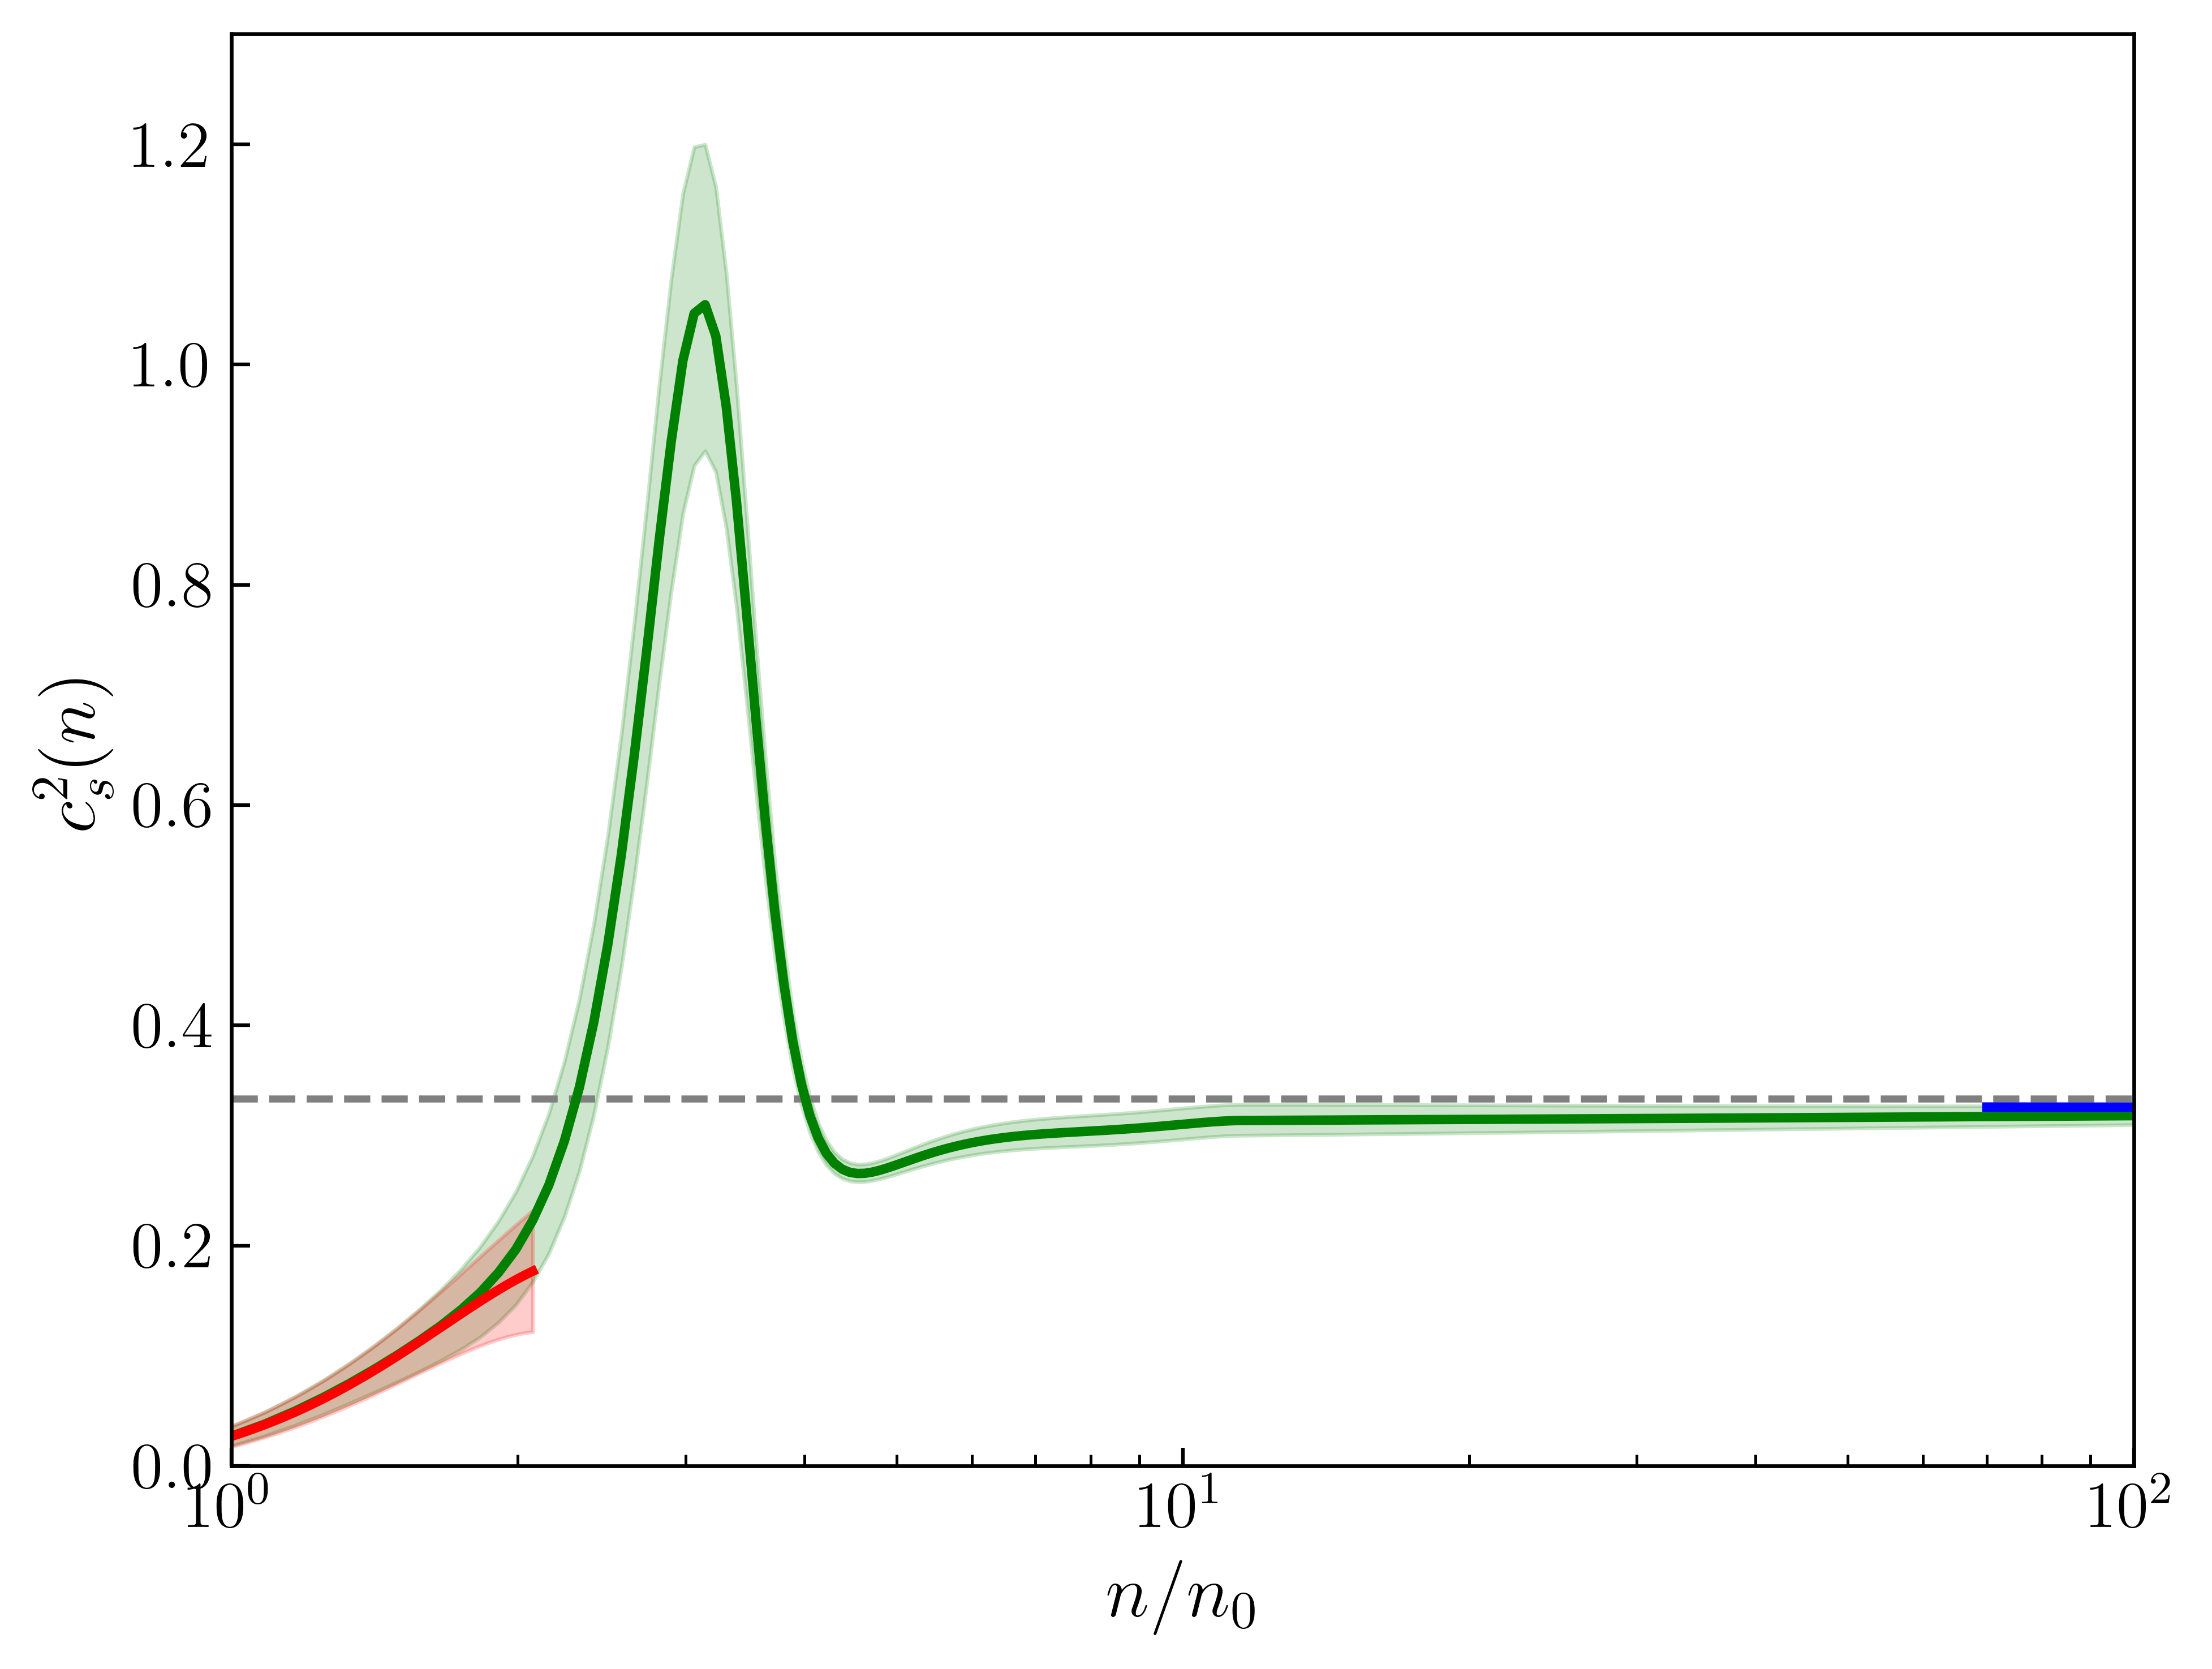

In [13]:
# plot the results
mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi'] = 600   # change for paper plots
mpl.rcParams['font.size'] = 8
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
WIDE_IMG_WIDTH = 800
NARROW_IMG_WIDTH = 400

# 1/3 conformal limit line
plt.axhline(y=0.333333, color='grey', linestyle='dashed')

# plotting the mixed model speed of sound
plt.plot(dens_cs2/n0, cs2_mean, color='g', linewidth=2, label=r'Mixed model')
plt.fill_between(dens_cs2/n0, cs2_lower, cs2_upper, color='g', alpha=0.2)

# plot the result from chiral EFT
npzfile = np.load('../data/eos_data/speedofsoundchiral.npz')
chiral_mean = npzfile['mean']
chiral_std = npzfile['std']
chiral_dens = npzfile['density']
plt.plot(chiral_dens/n0, chiral_mean[:,3], color='red', linewidth=2, label=r'ChEFT')
plt.fill_between(chiral_dens/n0, chiral_mean[:,3]+chiral_std[:,3], \
                 chiral_mean[:,3]-chiral_std[:,3], alpha=0.2, color='red')

# plot the result from pQCD
npzfile2 = np.load('../data/eos_data/pqcd_cs2_11.2.npz')
pqcd_cs2 = npzfile2['mean']
pqcd_dens = npzfile2['density']
pqcd_lower = npzfile2['lower']
pqcd_upper = npzfile2['upper']
plt.plot(pqcd_dens/n0, pqcd_cs2, color='blue', linewidth=2, label=r'pQCD')
plt.fill_between(pqcd_dens/n0, pqcd_lower, pqcd_upper, color='blue', alpha=0.2)

plt.xlim(1.0, 100.0)
plt.ylim(0.0, 1.3)
plt.xlabel(r'$n/n_{0}$', fontsize=16)
plt.ylabel(r'$c_{s}^{2}(n)$', fontsize=16)
plt.xscale('log')
plt.show()

## Creating the paper plot

And below we generate the paneled plot used in the paper. 

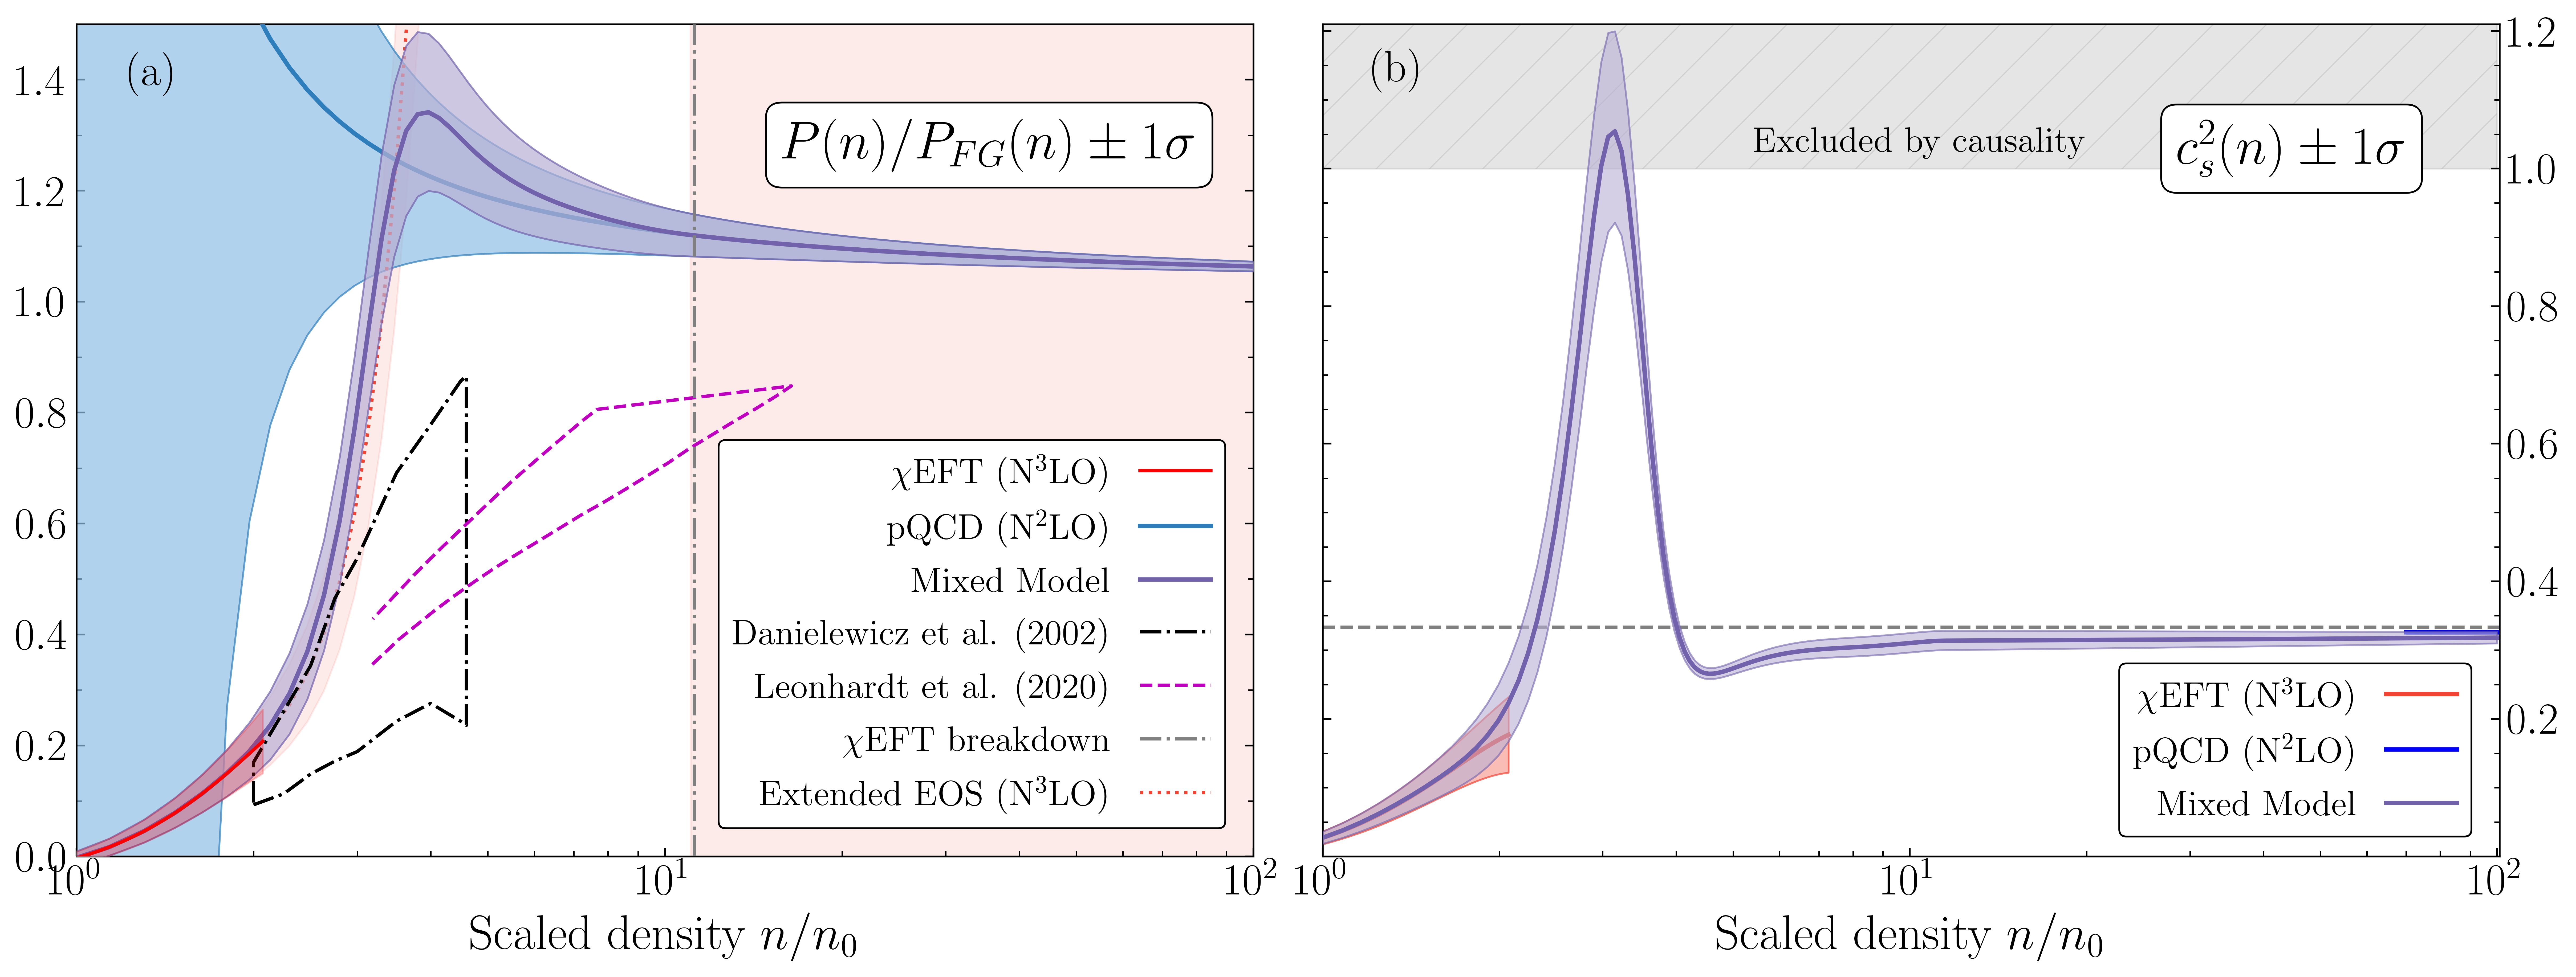

In [14]:
# Fig. 6 in our paper
# set up the plot requirements
fig, ax = plt.subplots(1, 2, figsize=(16,6), dpi=600, sharex='col')
#fig.patch.set_alpha(0.0)
ax[0].set_xlim(1.00, max(density/n0))
ax[0].set_ylim(0.0,1.5)
ax[0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[0].xaxis.set_major_locator(MultipleLocator(10))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0].text(1.5, 1.45, r'(a)', ha='right', va='top', fontsize=20)
ax[0].set_xlabel(r'Scaled density $n/n_{0}$', fontsize=22)
ax[0].set_xscale('log')

ax[1].set_xlim(1., max(density/n0)+1.)
ax[1].set_ylim(1e-6,1.21)
ax[1].xaxis.set_major_locator(MultipleLocator(10))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].text(
    70.0,1.07, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1].text(1.5, 1.175, r'(b)', ha='right', va='top', fontsize=20)
ax[1].set_xlabel(r'Scaled density $n/n_{0}$', fontsize=22)
ax[1].set_xscale('log')

orders = [0,1,2]

# plotting assistance
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues', 'Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

# pressure data

# model means and uncertainties
ax[0].fill_between(density/n0, mean_chiral - 1.0*std_dev_chiral, mean_chiral + 1.0*std_dev_chiral, \
                color=colors[0], alpha=0.1)

ax[0].fill_between(real_chiral['density']/n0, real_chiral['mean'][:,3]-real_chiral['std_dev'][:,3], \
                   real_chiral['mean'][:,3]+real_chiral['std_dev'][:,3], color='red', zorder=15, alpha=0.2)

ax[0].plot(real_chiral['density']/n0, real_chiral['mean'][:,3], label=labels[0], color='red', zorder=15)

ax[0].fill_between(density/n0, mean_pqcd - 1.0*std_dev_pqcd, mean_pqcd + 1.0*std_dev_pqcd, \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[0].plot(density/n0, mean_pqcd, zorder=3, linewidth=2, color=colors[1], label=labels[1])

# PPD band (testing data array)
ax[0].fill_between(density/n0, mixed_mean-1.0*mixed_std_dev, mixed_mean+ \
                   1.0*mixed_std_dev,
                       zorder=5, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[0].plot(density/n0, mixed_mean, color=colors[2], zorder=10, linewidth=2, label='Mixed Model')

# frg unscaling
density_test = density
pressure_free = np.zeros([len(df_frg['n/n0'])])
p_fg = np.zeros([len(density_test)])
hbarc = 197.327 # MeV fm

# contour kf_s calculated here
contour_kf_s_fg = fermi_momentum(density=density_test, degeneracy=4)
contour_kf_s = fermi_momentum(density=0.164*df_frg['n/n0'], degeneracy=4)

for i in range(len(df_frg['n/n0'])):
    pressure_free[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s[i]**4.0))*(hbarc)
p_fg = pqcd_convert_arr
    
# unscale FRG
frg_unscaled = df_frg['P/P_free']*pressure_free
ax[0].plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', zorder=10, \
           label='Danielewicz et al. (2002)')
ax[0].plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', zorder=10, \
           label='Leonhardt et al. (2020)')

# Q=1 location of chiral EFT
ax[0].axvline(x=1.84/n0, color='grey', linestyle='dashdot', zorder=10, label=r'$\chi$EFT breakdown')

# fake chiral
ax[0].plot(density/n0, mean_chiral, linestyle='dotted', color=colors[0], label=labels[3])

# legend
ax[0].legend(loc='lower right', facecolor='w', markerfirst=False, fontsize=16.0)

# speed of sound data 
ax[1].axhline(y=(1.0/3.0), color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
npzfile = np.load('../data/eos_data/speedofsoundchiral.npz')
chiral_mean = npzfile['mean'][:,3]
chiral_std = npzfile['std'][:,3]
chiral_dens = npzfile['density']
ax[1].fill_between(chiral_dens/n0, chiral_mean-1.0*chiral_std, \
                 chiral_mean+1.0*chiral_std, alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[1].plot(chiral_dens/n0, chiral_mean, color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
npzfile2 = np.load('../data/eos_data/pqcd_cs2_11.2.npz')
pqcd_cs2 = npzfile2['mean']
pqcd_dens = npzfile2['density']
pqcd_lower = npzfile2['lower']
pqcd_upper = npzfile2['upper']
ax[1].fill_between(pqcd_dens/n0, pqcd_lower, pqcd_upper, zorder=2, \
                   facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)
ax[1].plot(pqcd_dens/n0, pqcd_cs2, color='blue', linewidth=2, zorder=3, label=r'pQCD (N$^2$LO)')

# mixed model cs2 data
ax[1].fill_between(dens_cs2/n0, cs2_lower, cs2_upper, zorder=4, facecolor=light_colors[2], \
                   edgecolor=colors[2], alpha=0.6)
ax[1].plot(dens_cs2/n0, cs2_mean, color=colors[2], linewidth=2, zorder=5, label=r'Mixed Model')

# causality line
ax[1].fill_between(dens_cs2/n0, 1.0*np.ones(len(dens_cs2)), 1.21*np.ones(len(dens_cs2)), \
                   color='grey', alpha=0.2, hatch='/')
ax[1].legend(loc='lower right', bbox_to_anchor=[1,-0.01], facecolor='w', markerfirst=False, fontsize=16.0)
ax[1].text(20.0, 1.06, r'Excluded by causality', ha='right', va='top', fontsize=16)
plt.show()
fig.savefig('../plots/subplot_pointwise_model.PNG', bbox_inches='tight')

Author: Alexandra Semposki

01 April 2024